In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt


In [2]:
import numpy as np
import pandas as pd
import scipy.stats as stats

In [3]:
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [4]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [5]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [6]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [7]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [8]:
# Save references to each table
measurement = Base.classes.measurement
station = Base.classes.station

In [9]:
# Create our session (link) from Python to the DB
session = Session(bind=engine)

# Exploratory Climate Analysis

In [10]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results

# Calculate the date 1 year ago from the last data point in the database
last_date = session.query(measurement.date).order_by(measurement.date.desc()).first()
last_date = last_date[0]
last_date  = dt.datetime.strptime(last_date, '%Y-%m-%d')
first_date = last_date - dt.timedelta(days=365)


In [11]:
# Perform a query to retrieve the date and precipitation values
sel = [measurement.date, 
       measurement.prcp 
       ]

annual_rainfall = session.query(*sel).\
    filter(measurement.date >= first_date).\
    filter(measurement.date <= last_date).all()

# Save the query results as a Pandas DataFrame
rainfall_df = pd.DataFrame(annual_rainfall, columns=["Date", "Rainfall (In)"])

# Remove null values from the dataset ie temperature observation (tobs) recorded but no prcp
rainfall_df.dropna(inplace=True)  

# Set the index to the date column
rainfall_df.set_index("Date",inplace=True)

# Sort the dataframe by date
rainfall_df = rainfall_df.sort_values("Date", ascending=True)
rainfall_df.tail(5)

,Rainfall (In)
Date,
2017-08-22,0.50
2017-08-23,0.00
2017-08-23,0.08
2017-08-23,0.00
2017-08-23,0.45


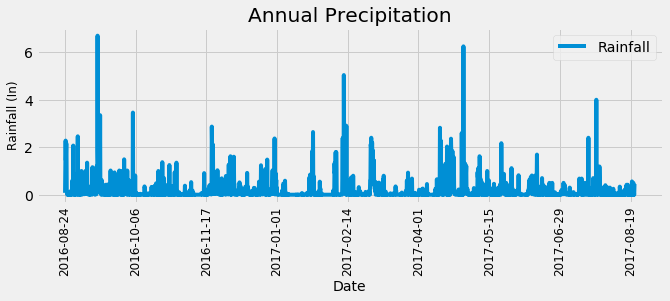

In [12]:
# Use Pandas Plotting with Matplotlib to plot the data
rainfall_df.plot(figsize=(10,3))

# Format plot
plt.title("Annual Precipitation")
plt.xlabel("Date", fontsize=14)
plt.ylabel("Rainfall (In)", fontsize=12)

plt.xticks(rotation = 90, fontsize=12)

plt.legend(["Rainfall"])
plt.show()


In [13]:
# Use Pandas to calculate the summary statistics for the precipitation data
rainfall_df.describe()

,Rainfall (In)
count,2015.000000
mean,0.176462
std,0.460288
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


In [14]:
# Design a query to show how many stations are available in this dataset
no_stations = session.query(measurement.station).group_by(measurement.station).count()
print(f"There are {no_stations} stations available in this dataset.")


There are 9 stations available in this dataset.


In [15]:
# What are the most active stations? (i.e. what stations have the most rows)
# List the stations and the counts in descending order
active_stations = session.query(measurement.station, station.name, func.count(measurement.station)).\
    filter(measurement.station == station.station).\
    group_by(measurement.station).\
    order_by(func.count(measurement.station).desc()).all()

stations_list = [station[0] for station in active_stations]

active_station_df = pd.DataFrame(active_stations, columns=["Station ID", "Station Name", "No. Observations"])
active_station_df


,Station ID,Station Name,No. Observations
0,USC00519281,"WAIHEE 837.5, HI US",2772
1,USC00519397,"WAIKIKI 717.2, HI US",2724
2,USC00513117,"KANEOHE 838.1, HI US",2709
3,USC00519523,"WAIMANALO EXPERIMENTAL FARM, HI US",2669
4,USC00516128,"MANOA LYON ARBO 785.2, HI US",2612
5,USC00514830,"KUALOA RANCH HEADQUARTERS 886.9, HI US",2202
6,USC00511918,"HONOLULU OBSERVATORY 702.2, HI US",1979
7,USC00517948,"PEARL CITY, HI US",1372
8,USC00518838,"UPPER WAHIAWA 874.3, HI US",511


In [16]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature of the most active station
temps = session.query(measurement.station, station.name, func.min(measurement.tobs),\
                      func.max(measurement.tobs),\
                      func.avg(measurement.tobs)).\
        filter(measurement.station == stations_list[0]).all()

temps_df = pd.DataFrame(temps, columns=["Station ID", "Station Name", "Lowest Temp", "Highest Temp", "Average Temp"])
temps_df.set_index("Station ID",inplace=True)

temps_df


,Station Name,Lowest Temp,Highest Temp,Average Temp
Station ID,,,,
USC00519281,"WAIKIKI 717.2, HI US",54.0,85.0,71.663781


In [17]:
# Choose the station with the highest number of temperature observations
# List the stations and the counts in descending order to find station with highest number of temperature observations
stn_most_temps = session.query(measurement.station, func.count(measurement.tobs)).\
    group_by(measurement.station).\
    order_by(func.count(measurement.tobs).desc()).first()

# Find the last date for the station
stn_last_date = session.query(measurement.date).\
    filter(measurement.station == stn_most_temps[0]).\
           order_by(measurement.date.desc()).first()

# Calculate the date 1 year ago from the last data point for the station
stn_last_date = stn_last_date[0]
stn_last_date  = dt.datetime.strptime(stn_last_date, '%Y-%m-%d')
stn_first_date = stn_last_date - dt.timedelta(days=365)

# Query the last 12 months of temperature observation data for this station
station_temps = session.query(measurement.tobs).\
    filter(measurement.station == stn_most_temps[0]).\
    filter(measurement.date >= stn_first_date).\
    filter(measurement.date <= stn_last_date).all()

station_temps_df = pd.DataFrame(station_temps, columns=["Rainfall (In)"])


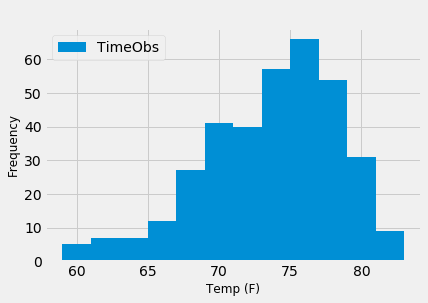

In [18]:
# Plot the results as a histogram
station_temps_df.hist(bins=12)
plt.xlabel("Temp (F)", fontsize=12)
plt.legend(["TimeObs"])
plt.ylabel("Frequency", fontsize=12)
plt.title(" ")
plt.show()

## Bonus Challenge Assignment

##### Temperature Analysis I

Hawaii is reputed to enjoy mild weather all year. Is there a meaningful difference between the temperature in, for example, June and December.  Identify the average temperature in June at all stations across all available years in the dataset. Do the same for December temperature and perform a t-test to determine whether the difference in the means, if any, is statistically significant.

#### A paired t-test will be used, also known as a repeated measures t-test, as we are testing the same group twice.  There are two possible hypotheses in a paired t-test:
* that there is no significant difference between the means of both groups (the null hypothesis) and
* that there is a significant difference between the means of both groups


In [19]:
# Identify the average temperature in June at all stations across all available years in the dataset.  Do the same for the
# December temperature.

# Study data files
measurements_path = "Resources/hawaii_measurements.csv"
stations_path = "Resources/hawaii_stations.csv"

# Read the measurement data and the station data
measurements_data = pd.read_csv(measurements_path)
stations_data = pd.read_csv(stations_path)

# Combine the data into a single dataset  
all_data_df = pd.merge(measurements_data, stations_data, how="left", on=["station", "station"])

# Display counts in the data table for completeness
all_data_df.count()


station      19550
date         19550
prcp         18103
tobs         19550
name         19550
latitude     19550
longitude    19550
elevation    19550
dtype: int64

In [20]:
all_data_df["month"] = pd.DatetimeIndex(all_data_df["date"]).month
all_data_df["year"] = pd.DatetimeIndex(all_data_df["date"]).year

june_df = all_data_df[all_data_df["month"].isin(["6"])]
dec_df = all_data_df[all_data_df["month"].isin(["12"])]

june_s = june_df.groupby(["station","year"]).tobs.mean()
dec_s = dec_df.groupby(["station","year"]).tobs.mean()

stats.ttest_ind(june_s, dec_s, equal_var=False)


Ttest_indResult(statistic=9.727148987834655, pvalue=7.70364426501627e-17)

Based on the p-value above, the December average temperature is different to the June average temperature.  As the p-value is below the alpha (ie p < 0.05) the observed difference is statistically significant



##### Temperature Analysis II

In [21]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(measurement.tobs), func.avg(measurement.tobs), func.max(measurement.tobs)).\
        filter(measurement.date >= start_date).filter(measurement.date <= end_date).all()

# function usage example
print(calc_temps('2012-02-28', '2012-03-05'))


[(62.0, 69.57142857142857, 74.0)]


In [22]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# For your trip using the previous year's data for those same dates (chose 16/02/18 -> 05/03/18).
start_date = '2017-02-16'
end_date = '2017-03-02'

temp_results = calc_temps(start_date, end_date)


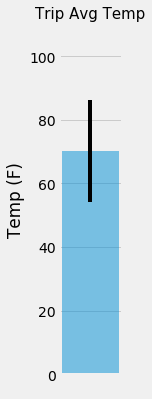

In [23]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)
tmin, tave, tmax = temp_results[0]
yerr = tmax-tmin
x = " "
y = tave

# Build the plot
plt.figure(figsize=(1,6))
plt.bar(x, tave, yerr=yerr, alpha=0.5, ecolor="black")

plt.title("Trip Avg Temp", fontsize = 15)

plt.grid(axis="x")
plt.ylabel("Temp (F)")
plt.ylim(top=110)

plt.show()


In [24]:
# Calculate the total amount of rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation
sel = [measurement.station, 
       station.name,
       station.latitude,
       station.longitude,
       station.elevation,
       func.sum(measurement.prcp)]

station_rainfall = session.query(*sel).\
    filter(measurement.station == station.station).\
    filter(measurement.date >= start_date).\
    filter(measurement.date <= end_date).\
    group_by(measurement.station).\
    order_by(func.sum(measurement.prcp).desc()).all()

station_rainfall_df = pd.DataFrame(station_rainfall, columns=["Station ID", "Station Name",\
                                                              "Latitude", "Longitude", "Elevation", "Rainfall (In)"])
station_rainfall_df


,Station ID,Station Name,Latitude,Longitude,Elevation,Rainfall (In)
0,USC00519281,"WAIHEE 837.5, HI US",21.45167,-157.84889,32.9,5.05
1,USC00513117,"KANEOHE 838.1, HI US",21.42340,-157.80150,14.6,4.67
2,USC00516128,"MANOA LYON ARBO 785.2, HI US",21.33310,-157.80250,152.4,3.90
3,USC00517948,"PEARL CITY, HI US",21.39340,-157.97510,11.9,3.01
4,USC00519523,"WAIMANALO EXPERIMENTAL FARM, HI US",21.33556,-157.71139,19.5,2.94
5,USC00519397,"WAIKIKI 717.2, HI US",21.27160,-157.81680,3.0,2.15
6,USC00514830,"KUALOA RANCH HEADQUARTERS 886.9, HI US",21.52130,-157.83740,7.0,1.95


In [25]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(measurement.tobs), func.avg(measurement.tobs), func.max(measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", measurement.date) == date).all()
    
daily_normals("01-01")


[(62.0, 69.15384615384616, 77.0)]

In [26]:
# Calculate the daily normals for your trip
# Push each tuple of calculations into a list called `normals`
days_list = []
normals = []

# Start and end date of the trip set above
start_date = '2017-02-16'
end_date = '2017-03-02'

start_date  = dt.datetime.strptime(start_date, '%Y-%m-%d')
end_date = dt.datetime.strptime(end_date, '%Y-%m-%d')

# Use the start and end date to create a range of dates
date_range = [start_date + dt.timedelta(days = x) for x in range(0, (end_date - start_date).days)]

# Strip off the year and save a list of %m-%d strings
for x in range(0,len(date_range)):
    month_day = date_range[x].strftime("%m-%d")
    days_list.append(month_day)

# Loop through the list of %m-%d strings and calculate the normals for each date
for x in range(0,len(days_list)):
    date = daily_normals(days_list[x])
    tmin, tave, tmax = date[0]
    normals.append(date[0])


In [27]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index
# create DataFrame using data 
trip_dates = []

trip_df = pd.DataFrame(normals, columns=["Min","Average","Maximum"])

# Convert date range from datetime to iso format
for x in range(0,len(date_range)):
    trip_day = date_range[x].strftime("%y-%m-%d")
    trip_dates.append(trip_day)

# Add trip dates range to the dateframe and set as index
trip_df["Trip Dates"] = trip_dates
trip_df.set_index("Trip Dates",inplace=True)


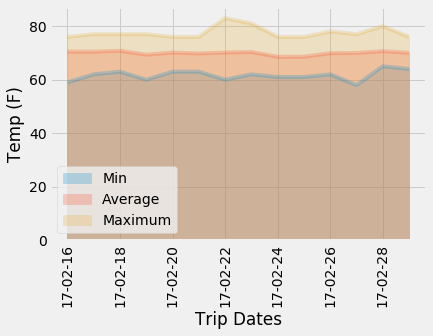

In [28]:
# Plot the daily normals as an area plot with `stacked=False`
trip_df.plot.area(stacked=False, alpha=0.25)
plt.ylabel("Temp (F)")
plt.xticks(rotation = 90)
plt.show()
